## Import library

In [1]:
import torch
import torchvision
from torchsummary import summary
import numpy as np
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn

## Load Pretrained Model

In [183]:
model = models.vgg19(weights='IMAGENET1K_V1')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(device)

cuda:0


In [184]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [185]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Freeze Model

In [91]:
for param in model.parameters():
    param.requires_grad = False

## Modify Model

In [92]:
num_classes = 10
# Todo modify pretrained vgg19 last few layer
# Linear(4096, 512) => ReLU() => Dropout(0.5) => Linear(512, num_classes)
model.classifier[6] = nn.Linear(4096, 512)
model.classifier.append(nn.ReLU())
model.classifier.append(nn.Dropout(0.5))
model.classifier.append(nn.Linear(512, num_classes))

model = model.to(device)

## Load Dataset

In [17]:
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

images.shape

torch.Size([32, 3, 32, 32])

## Different method to resize images
check difference between each method. I think they are similar

In [23]:
import skimage
import skimage.io
import skimage.transform
import cv2

In [40]:
image = images[0].numpy()
image = np.transpose(image, (1, 2, 0))

print(image.shape)
ski_resize_image = skimage.transform.resize(image, (224, 224), mode='constant')
cv2_resize_image = cv2.resize(image, (224, 224))
transform = transforms.Resize((224, 224))
torch_transform_image = np.transpose(transform(images[0]).numpy(), (1, 2, 0))

print(ski_resize_image.shape)
print(cv2_resize_image.shape)
print(torch_transform_image.shape)

cv2.imshow('Original Image', image)
cv2.imshow('ski_resize_image', ski_resize_image)
cv2.imshow('cv2_resize_image', cv2_resize_image)
cv2.imshow('torch_transform_image', torch_transform_image)


cv2.waitKey(0)

cv2.destroyAllWindows()

(32, 32, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


## Reload Dataset

In [6]:
# Bigger image size longer training time
image_size = (32, 32)

transform_train = transforms.Compose([transforms.Resize(image_size),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=batch_size)

dataiter = iter(trainloader)
images, labels = next(dataiter)

images.shape

Files already downloaded and verified
Files already downloaded and verified


torch.Size([32, 3, 32, 32])

## Loss Function and Optimizer

In [93]:
lr = 0.001
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Train Model

In [132]:
import copy

def train(model, criterion, optimzer, num_epochs, trainloader, testloader=None):
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': [],
               'best_model_weight': None,
               'best_model_acc': (0, 0.0)}
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    # Early Stop
    best_val_loss = float('inf')
    patience = 3
    no_improvement_count = 0
    
    for e in range(num_epochs):
        model.train()
        print(f'\033[1;33m======================Epoch:{e}======================\033[0m')
        train_loss = 0.0
        train_acc = 0.0
        train_sample_size = len(trainloader.dataset)
        
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backpropagation and Optimization
            loss.backward()
            optimizer.step()
            
            # Store result
            _, pred = torch.max(outputs, 1)
            train_loss += loss.item()
            train_acc += (pred == labels).sum().item()
            
        # Divice by sample size
        train_loss /= train_sample_size
        train_acc /= train_sample_size
        # Logging
        print(f'\033[1;34mTrain Loss:{train_loss:.2f}\033[0m')
        print(f'\033[1;35mTrain Acc:{train_acc:.2f}\033[0m')
        
        # Store best model
        if train_acc > history['best_model_acc'][1]:
            history['best_model_acc'] = (e, train_acc)
#             history['best_model_weight'] = copy.deepcopy(model.state_dict())
            
        # Evaluate model
        val_loss = 0.0
        val_acc = 0.0
        val_sample_size = len(testloader.dataset)
        if testloader:
            model.eval()
            with torch.no_grad():
                for batch_idx, (inputs, labels) in enumerate(testloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    # Calculate loss
                    loss = criterion(outputs, labels)

                    # Store result
                    _, pred = torch.max(outputs, 1)
                    val_loss += loss.item()
                    val_acc += (pred == labels).sum().item()
                    
                val_loss /= val_sample_size
                val_acc /= val_sample_size
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                
        print(f'\033[1;34mValidation Loss:{val_loss:.2f}\033[0m')
        print(f'\033[1;35mValidation Acc:{val_acc:.2f}\033[0m')
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Early Stop Condition
        if no_improvement_count >= patience:
            print(f"Early stopping after {e} epochs with no improvement.")
            break
    
    return model, history

In [134]:
model, history = train(model, criterion, optimizer, 1, trainloader, testloader)

======================Epoch:0======================
Train Loss:0.04
Train Acc:0.57
Validation Loss:0.04
Validation Acc:0.59


## Plot history

In [141]:
import matplotlib.pyplot as plt

def plot_history(history):
    train_loss = history['train_loss']
    train_acc = history['train_acc']
    val_loss = history['val_loss']
    val_acc = history['val_acc']        
    x = list(range(len(train_loss)))
    
    plt.figure(figsize=(12,7))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_loss, label='Train Loss', color='blue')
    plt.plot(x, val_loss, label='Val Loss', color='brown')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, train_acc, label='Train Acc', color='blue')
    plt.plot(x, val_loss, label='Val Acc', color='brown')
    plt.plot(history['best_model_acc'][0], history['best_model_acc'][1], 'o', label='Best Train Acc', color='blue')
    plt.title('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

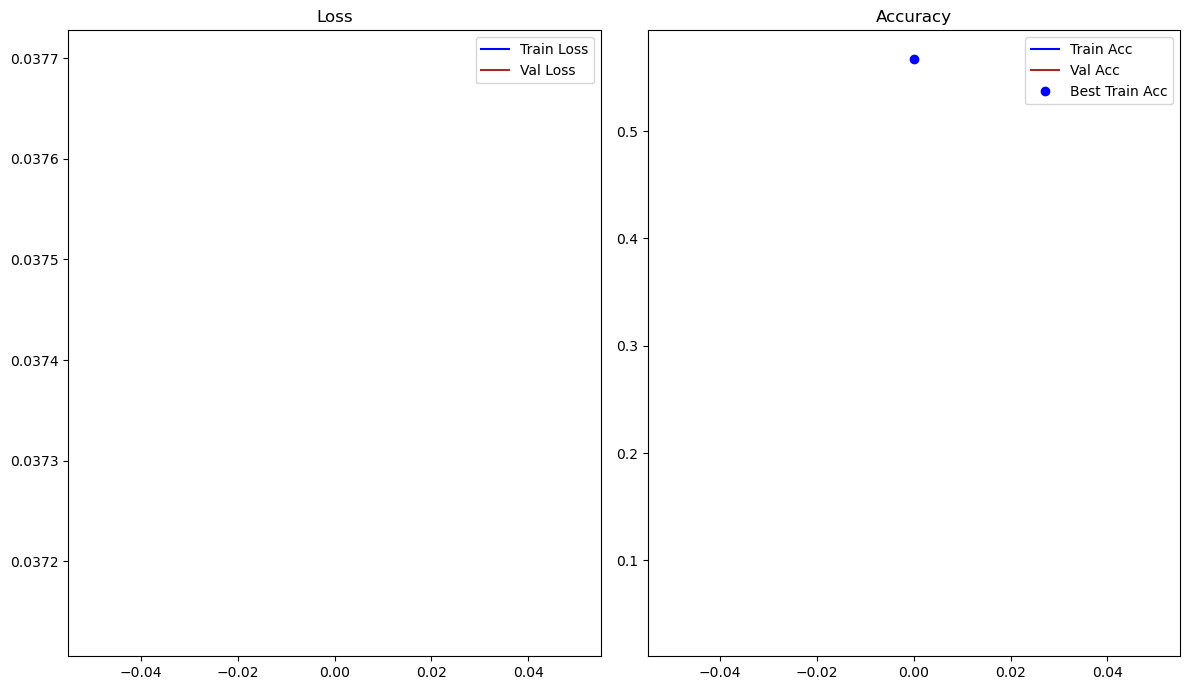

In [142]:
plot_history(history)

## Evaluate with one image

In [11]:
import matplotlib.pyplot as plt

img_path = 'bird.jpg'
image = plt.imread(img_path)

test_image_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(image_size,antialias=True) ])
convert_image = test_image_transform(image)
print(image.shape, convert_image.shape)

(2592, 3888, 3) torch.Size([3, 32, 32])


C:\Users\junee\anaconda3\envs\python3_8\lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


## Load Model

In [12]:
model_path = 'vgg19_32x32.pth'
test_model = torch.load(model_path).to(device)
test_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Confidence:0.7412529587745667  Prediction Label:bird  True Label:Bird


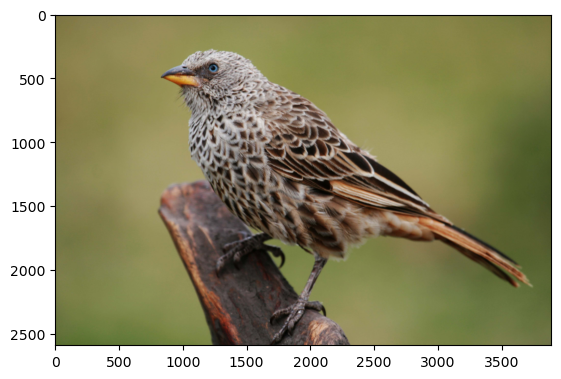

In [13]:
convert_image = convert_image.to(device)
outputs = test_model(convert_image.unsqueeze(0))
outputs = nn.functional.softmax(outputs, dim=1)

confidence, pred = torch.max(outputs, 1)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'Confidence:{confidence.item()}  Prediction Label:{classes[pred]}  True Label:Bird')
plt.imshow(image)

## 20 Images Prediction
randomly pick 20 images doing classifier

In [18]:
testiter = iter(testloader)
images, labels = next(testiter)
images = images.to(device)
labels = labels.to(device)

test_model.eval()

with torch.no_grad():
    outputs = test_model(images)
    outputs = nn.functional.softmax(outputs, dim=1)
    
# unnormalize images
show_images = np.transpose(images.cpu().numpy(), (0, 2, 3, 1))
show_images = show_images/2 + 0.5
show_images = show_images.clip(0, 1)

confidences, preds = torch.max(outputs, 1)
confidences = confidences.cpu().detach().numpy()
preds = preds.cpu().detach().numpy()
print(confidences, preds)


[0.18352467 0.44547904 0.19858935 0.6991783  0.94137335 0.5403186
 0.5847805  0.83138424 0.3319158  0.47731757 0.9417606  0.59804213
 0.61234117 0.659364   0.75548464 0.44547012 0.45412096 0.81677073
 0.87210816 0.52293277 0.7868917  0.7562997  0.864333   0.66101116
 0.7874466  0.65621084 0.3450967  0.9957587  0.4103887  0.5696514
 0.99738735 0.4446033 ] [4 5 1 2 6 8 2 6 2 8 7 6 2 8 2 6 5 7 1 7 9 7 7 1 6 6 6 1 8 4 8 4]


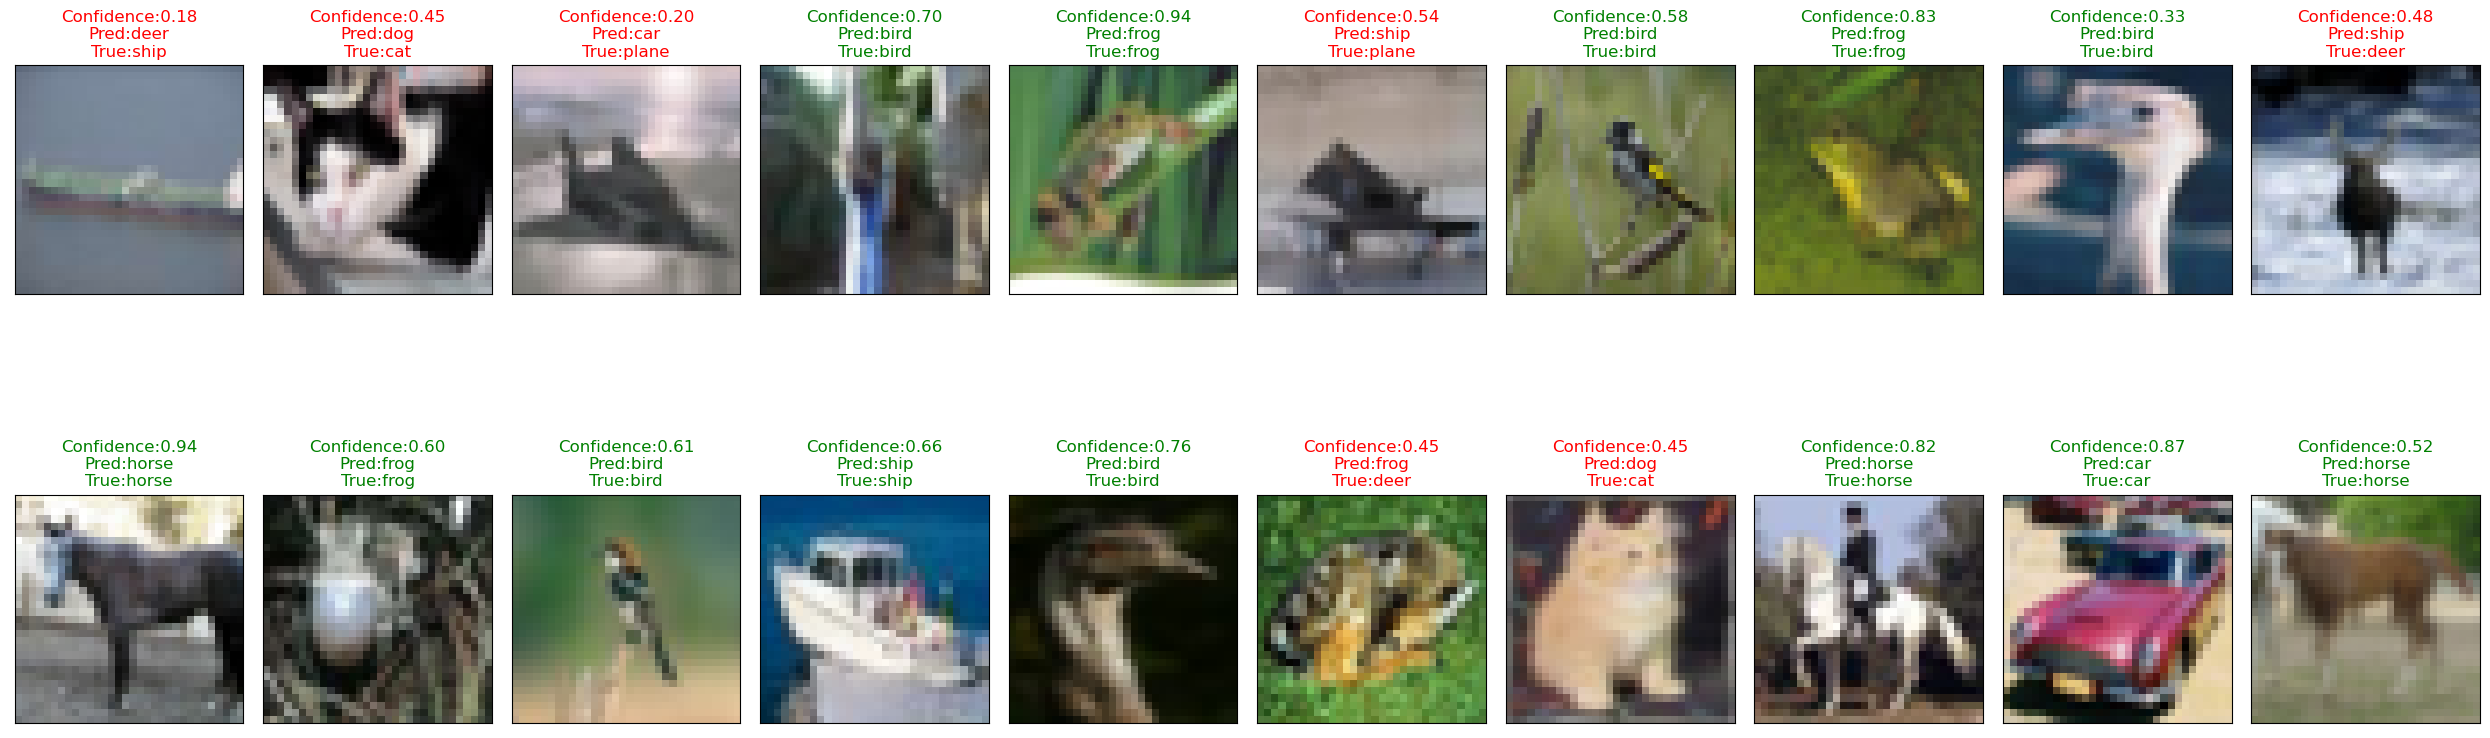

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,10))
for i in range(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.set_title(f'Confidence:{confidences[i]:.2f}\nPred:{classes[preds[i]]}\nTrue:{classes[labels[i]]}', color=("green" if preds[i] == labels[i] else "red"))
    plt.imshow(show_images[i])
    
plt.tight_layout()
plt.show()

## Confusion Matrix

In [21]:
test_model.eval()

preds_numpy = np.array([])
labels_numpy = np.array([])

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = test_model(inputs)
        outputs = nn.functional.softmax(outputs, dim=1)
        
        _, preds = torch.max(outputs, 1)
        preds_numpy = np.concatenate((preds_numpy, preds.cpu().detach().numpy()))
        labels_numpy = np.concatenate((labels_numpy, labels.cpu().detach().numpy()))    

In [24]:
print(preds_numpy[0:5], labels_numpy[0:5])

[8. 4. 5. 5. 1.] [8. 2. 3. 3. 5.]


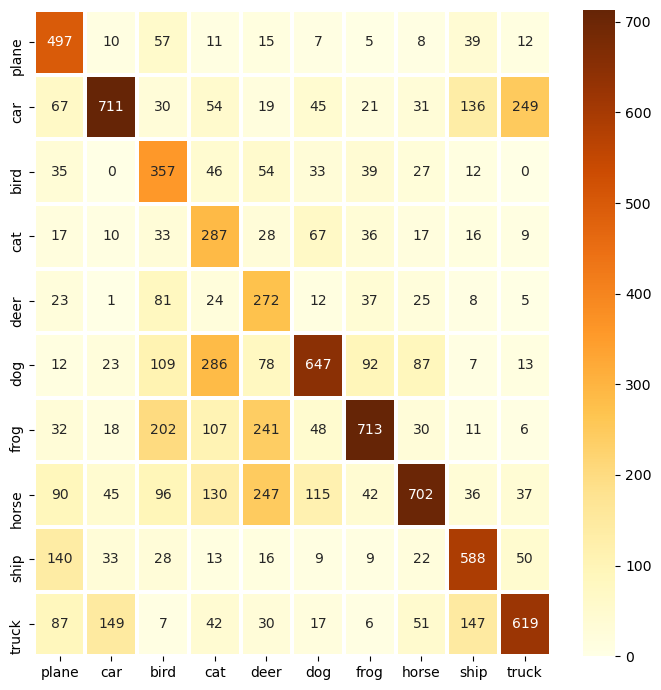

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(preds_numpy, labels_numpy)
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm,annot=True,linewidths=1.5,fmt=".0f",cmap="YlOrBr", ax=ax)
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.tight_layout()
plt.show()

## Save Model

In [ ]:
model_path = 'vgg19_cifar10_32x32.pth'
torch.save(model, model_path)